In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Year                             2938 non-null   int64  
 1   Status                           2938 non-null   object 
 2   Life expectancy                  2928 non-null   float64
 3   Adult Mortality                  2928 non-null   float64
 4   infant deaths                    2938 non-null   int64  
 5   Alcohol                          2744 non-null   float64
 6   percentage expenditure           2938 non-null   float64
 7   Hepatitis B                      2385 non-null   float64
 8   Measles                          2938 non-null   int64  
 9   BMI                              2904 non-null   float64
 10  under-five deaths                2938 non-null   int64  
 11  Polio                            2919 non-null   float64
 12  Total expenditure   

# Testing

## Optimization and plot functions

In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint
import optuna


def grid_search_optimization(X_train, y_train, X_test, y_test, preprocessor, model_class):

    if model_class.__name__ == "RandomForestRegressor":
        param_grid = {
            'model__n_estimators': [50, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    elif model_class.__name__ == "DecisionTreeRegressor":
        param_grid = {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
    else:
        raise ValueError(f"Unsupported model class: {model_class.__name__}")

    model = model_class(random_state=42)
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    print(f'GridSearchCV - RMSE on test set: {test_rmse}')
    print(f'GridSearchCV - R2 on test set: {test_r2}')
    
    return best_model, grid_search.best_params_, full_pipeline


def randomized_search_optimization(X_train, y_train, X_test, y_test, preprocessor, model_class):

    if model_class.__name__ == "RandomForestRegressor":
        param_dist = {
            'model__n_estimators': randint(50, 200),
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': randint(2, 5)
        }
    elif model_class.__name__ == "DecisionTreeRegressor":
        param_dist = {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': randint(2, 5)
        }
    else:
        raise ValueError(f"Unsupported model class: {model_class.__name__}")

    model = model_class(random_state=42)    
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    random_search = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, n_iter=10, cv=5, 
                                       scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    
    best_model = random_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    print(f'RandomizedSearchCV - RMSE on test set: {test_rmse}')
    print(f'RandomizedSearchCV - R2 on test set: {test_r2}')
    
    return best_model, random_search.best_params_, full_pipeline


def optuna_optimization(X_train, y_train, X_test, y_test, preprocessor, model_class):
    def objective(trial):
        if model_class.__name__ == "RandomForestRegressor":
            n_estimators = trial.suggest_int('n_estimators', 50, 200)
            max_depth = trial.suggest_int('max_depth', 10, 20)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
            model = model_class(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
        elif model_class.__name__ == "DecisionTreeRegressor":
            max_depth = trial.suggest_int('max_depth', 10, 20)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
            model = model_class(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                random_state=42
            )
        else:
            raise ValueError(f"Unsupported model class: {model_class.__name__}")
        
        full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        full_pipeline.fit(X_train, y_train)
        
        y_pred = full_pipeline.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        return rmse
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)
    
    best_params = study.best_params
    print("Optuna - Best parameters found:", best_params)
    
    # Create a new model with the best parameters
    if model_class.__name__ == "RandomForestRegressor":
        best_model = model_class(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            random_state=42
        )
    elif model_class.__name__ == "DecisionTreeRegressor":
        best_model = model_class(
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            random_state=42
        )
    
    # Build a new pipeline with the best model
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', best_model)
    ])
    full_pipeline.fit(X_train, y_train)
    
    y_pred = full_pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    print(f'Optuna - RMSE on test set: {test_rmse}')
    print(f'Optuna - R2 on test set: {test_r2}')
    
    return best_model, best_params, full_pipeline


def plot_model_evaluation(y_test, y_pred, X_train, full_pipeline, test_rmse, test_r2):
    
    # 1. Gráfico de "Actual vs Predicted"
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', lw=2, ls='--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Life Expectancy')
    plt.ylabel('Predicted Life Expectancy')
    plt.show()

    # 2. Gráfico de "Residuals"
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), color='red', lw=2, ls='--')
    plt.title('Residuals Plot')
    plt.xlabel('Predicted Life Expectancy')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()

    # 3. Gráfico de "Feature Importance"
    ohe = full_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot_encoder']
    ohe_feature_names = ohe.get_feature_names_out(X_train.select_dtypes(include=['object']).columns)
    
    numerical_cols = X_train.select_dtypes(exclude=['object']).columns
    all_feature_names = np.concatenate([numerical_cols, ohe_feature_names])
    
    importances = full_pipeline.named_steps['model'].feature_importances_
    indices = np.argsort(importances)
    
    # 4. Plot de importância das features com nomes corretos
    plt.figure(figsize=(10, 6))
    plt.barh(all_feature_names[indices], importances[indices])
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    # 5. Gráfico de métricas de desempenho do modelo (RMSE e R²)
    metrics = {'RMSE': test_rmse, 'R²': test_r2}
    plt.figure(figsize=(6, 4))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green'])
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.show()

## Random Forest Regressor

### Optimizing

#### Grid Search

In [17]:
best_model_RF_grid, best_params_grid, full_pipeline_grid = grid_search_optimization(X_train, y_train, X_test, y_test, preprocessor, RandomForestRegressor)

GridSearchCV - RMSE on test set: 1.6370319570495142
GridSearchCV - R2 on test set: 0.9690752028625391


In [18]:
y_pred_grid = best_model_RF_grid.predict(X_test)

test_rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
test_r2_grid = r2_score(y_test, y_pred_grid)

##### Interpretação

In [19]:
print(f"Final RMSE on test set: {test_rmse_grid}")
print(f"Final R² on test set: {test_r2_grid}")
print(f"Best hyperparameters: {best_params_grid}")

model = best_model_RF_grid.named_steps['model']

importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

for i in range(10):
    print(f'{X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}')

Final RMSE on test set: 1.6370319570495142
Final R² on test set: 0.9690752028625391
Best hyperparameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Total expenditure: 0.5912
thinness  1-19 years: 0.1650
Year: 0.1216
Income composition of resources: 0.0329
thinness 5-9 years: 0.0112
Measles: 0.0110
Population: 0.0087
Hepatitis B: 0.0073
Adult Mortality: 0.0062
under-five deaths: 0.0051


##### Plot

In [20]:
#plot_model_evaluation(y_test, y_pred_grid, X_train, best_model_grid, test_rmse_grid, test_r2_grid)

#### Randomized Search

In [21]:
best_model_RF_random, best_params_random, full_pipeline_random = randomized_search_optimization(X_train, y_train, X_test, y_test, preprocessor, RandomForestRegressor)

RandomizedSearchCV - RMSE on test set: 1.6474635673869478
RandomizedSearchCV - R2 on test set: 0.9686798247945912


In [22]:
y_pred_random = best_model_RF_random.predict(X_test)

test_rmse_random = np.sqrt(mean_squared_error(y_test, y_pred_random))
test_r2_random = r2_score(y_test, y_pred_random)

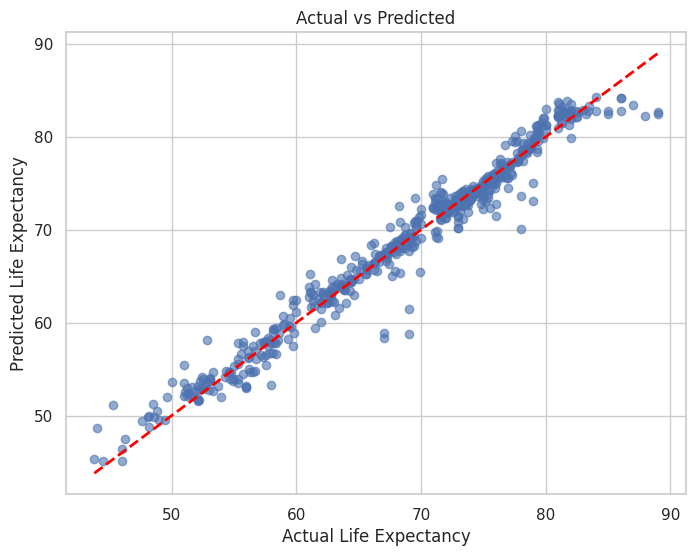

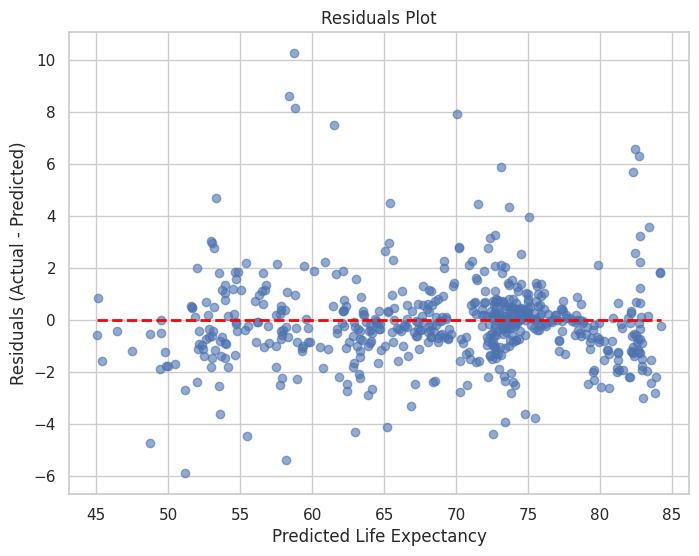

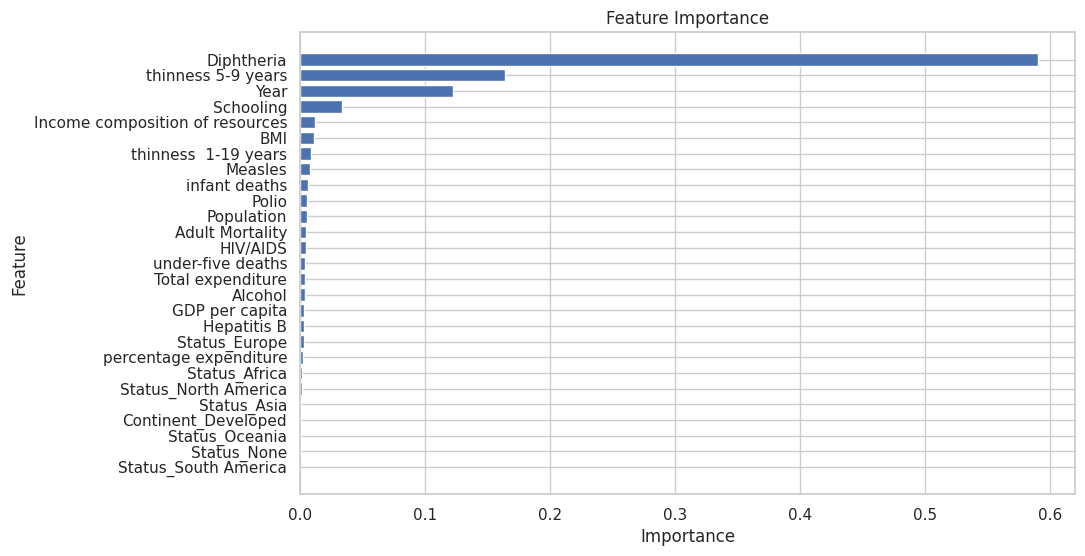

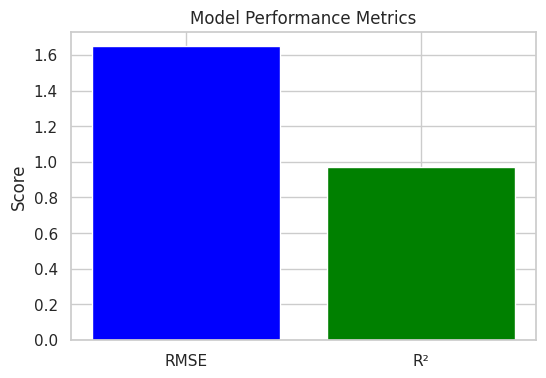

In [23]:
plot_model_evaluation(y_test, y_pred_random, X_train, best_model_RF_random, test_rmse_random, test_r2_random)

#### Optuna

In [24]:
# best_model_RF_optuna, best_params_optuna, full_pipeline_optuna = optuna_optimization(X_train, y_train, X_test, y_test, preprocessor, RandomForestRegressor)

In [25]:
# X_test_preprocessed = preprocessor.transform(X_test)
# y_pred_optuna = best_model_RF_optuna.predict(X_test_preprocessed)

# test_rmse_optuna = np.sqrt(mean_squared_error(y_test, y_pred_optuna))
# test_r2_optuna = r2_score(y_test, y_pred_optuna)

In [26]:
# plot_model_evaluation(y_test, y_pred_optuna, X_train, full_pipeline_optuna, test_rmse_optuna, test_r2_optuna)

## Decision Tree Regressor

### Optimizing

#### Grid Search

In [27]:
best_model_DT_grid, best_params_grid, full_pipeline_grid = grid_search_optimization(X_train, y_train, X_test, y_test, preprocessor, DecisionTreeRegressor)

GridSearchCV - RMSE on test set: 2.429072595231878
GridSearchCV - R2 on test set: 0.931911536636658


In [28]:
y_pred_grid = best_model_RF_grid.predict(X_test)

test_rmse_grid = np.sqrt(mean_squared_error(y_test, y_pred_grid))
test_r2_grid = r2_score(y_test, y_pred_grid)

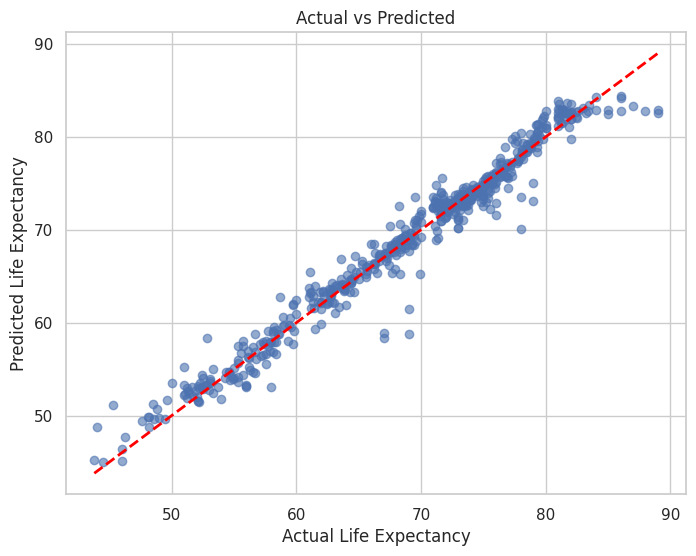

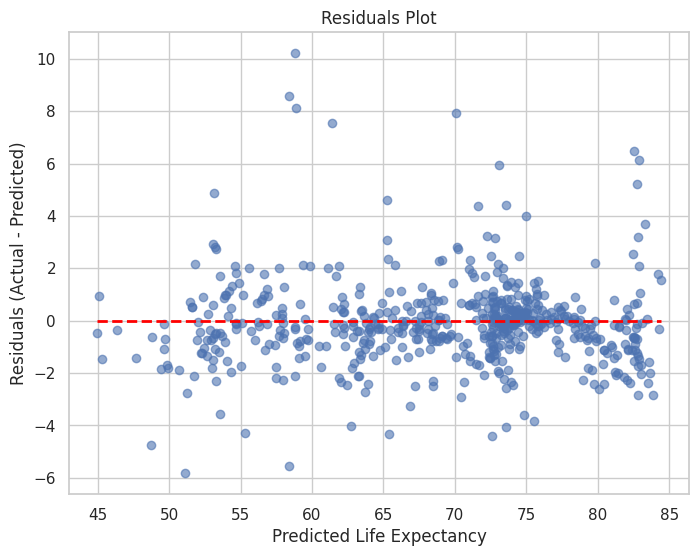

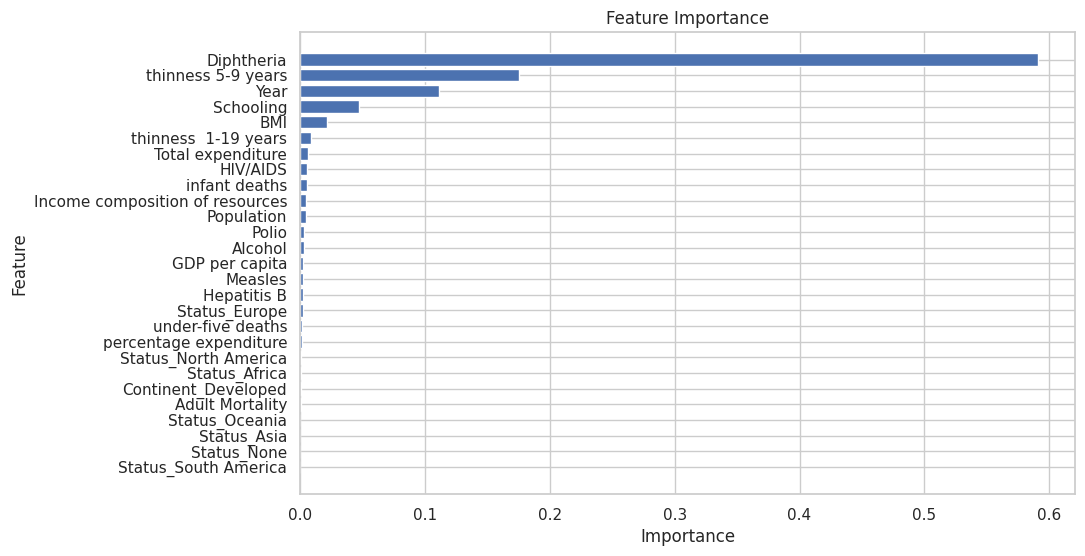

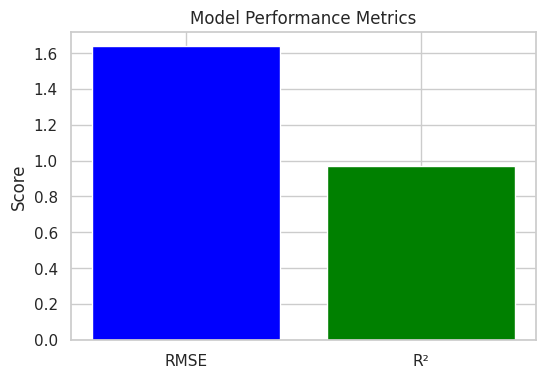

In [29]:
plot_model_evaluation(y_test, y_pred_grid, X_train, best_model_DT_grid, test_rmse_grid, test_r2_grid)

#### Randomized Search

In [30]:
best_model_DT_random, best_params_random, full_pipeline_random = randomized_search_optimization(X_train, y_train, X_test, y_test, preprocessor, DecisionTreeRegressor)

RandomizedSearchCV - RMSE on test set: 2.435159492242957
RandomizedSearchCV - R2 on test set: 0.9315698698318012


In [31]:
y_pred_random = best_model_RF_random.predict(X_test)

test_rmse_random = np.sqrt(mean_squared_error(y_test, y_pred_random))
test_r2_random = r2_score(y_test, y_pred_random)

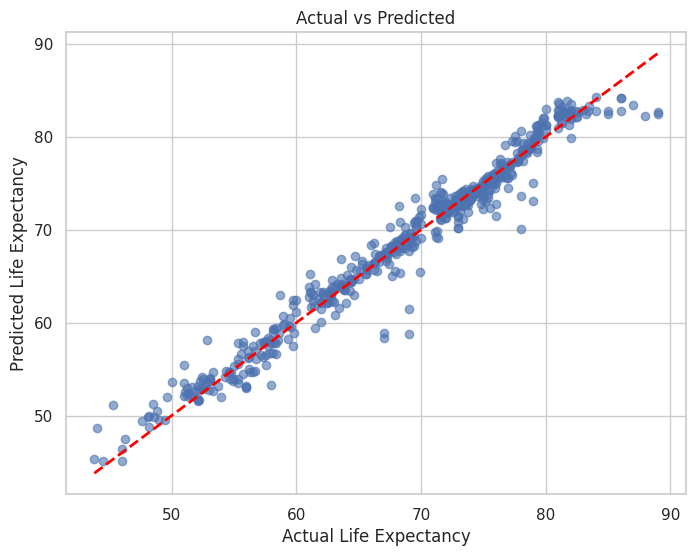

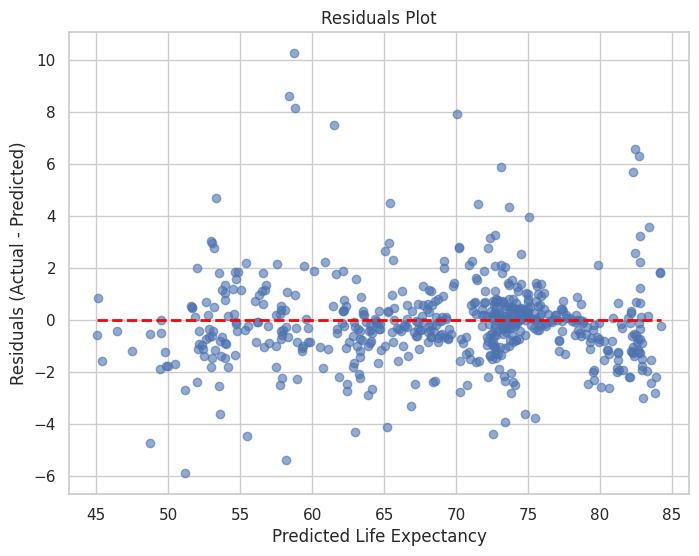

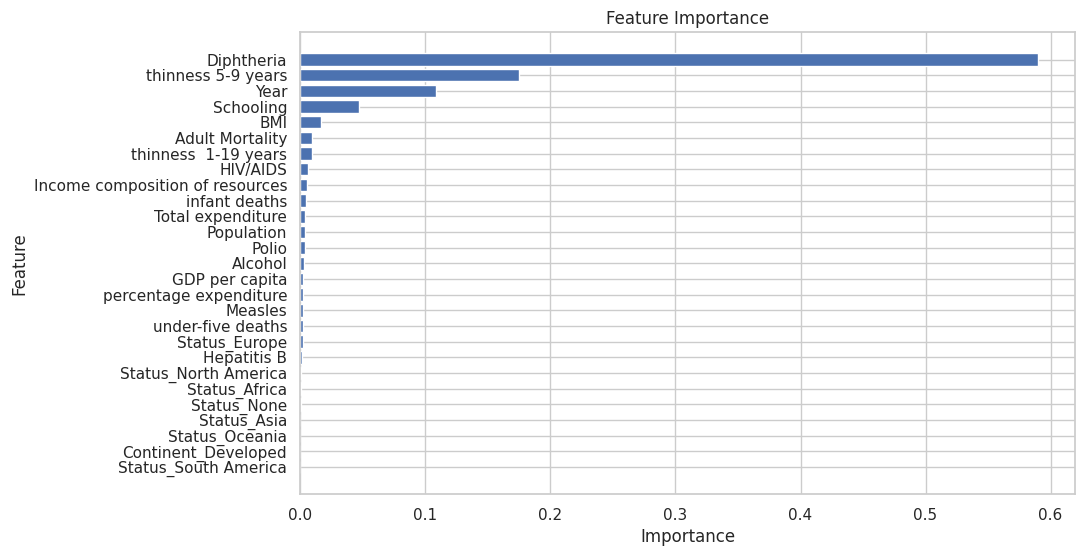

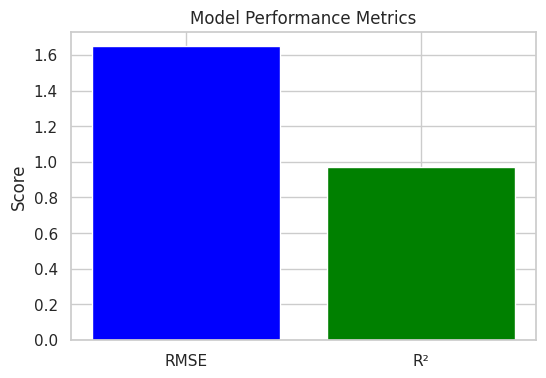

In [32]:
plot_model_evaluation(y_test, y_pred_random, X_train, best_model_DT_random, test_rmse_random, test_r2_random)

In [33]:
# best_model_DT_optuna, best_params_optuna, full_pipeline_optuna = optuna_optimization(X_train, y_train, X_test, y_test, preprocessor, DecisionTreeRegressor)

In [34]:
# X_test_preprocessed = preprocessor.transform(X_test)
# y_pred_optuna = best_model_DT_optuna.predict(X_test_preprocessed)

# test_rmse_optuna = np.sqrt(mean_squared_error(y_test, y_pred_optuna))
# test_r2_optuna = r2_score(y_test, y_pred_optuna)

In [35]:
# plot_model_evaluation(y_test, y_pred_optuna, X_train, full_pipeline_optuna, test_rmse_optuna, test_r2_optuna)

# Avaliação de Desempenho

In [36]:
models = [best_model_RF_grid, best_model_RF_random, best_model_DT_random, best_model_DT_grid]

results = {}
scoring = {'RMSE': 'neg_root_mean_squared_error', 'R2': 'r2'}

for model in models:
    if isinstance(model, Pipeline):
        model_name = model.named_steps['model'].__class__.__name__
    else:
        model_name = model.__class__.__name__
    
    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=10,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )
    cv_results['test_RMSE'] = -cv_results['test_RMSE']

    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    results[model_name] = {
        'cv_rmse_mean': cv_results['test_RMSE'].mean(),
        'cv_rmse_std': cv_results['test_RMSE'].std(),
        'cv_r2_mean': cv_results['test_R2'].mean(),
        'cv_r2_std': cv_results['test_R2'].std(),
        'cv_r2': cv_results['test_R2'],
        'cv_rmse': cv_results['test_RMSE'],
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'y_test': y_test,
        'y_pred': y_pred,
        'model': model
    }

In [37]:
df_results = pd.DataFrame(columns=['Modelo', 'CV RMSE', 'CV R²', 'Teste RMSE', 'Teste R²'])

for model_name, metrics in results.items():
    df_results = pd.concat([df_results, pd.DataFrame({
        'Modelo': [model_name],
        'CV RMSE': [f"{metrics['cv_rmse_mean']:.4f} ± {metrics['cv_rmse_std']:.4f}"],
        'CV R²': [f"{metrics['cv_r2_mean']:.4f} ± {metrics['cv_r2_std']:.4f}"],
        'Teste RMSE': [f"{metrics['test_rmse']:.4f}"],
        'Teste R²': [f"{metrics['test_r2']:.4f}"]
    })], ignore_index=True)

In [38]:
df_results

,Modelo,CV RMSE,CV R²,Teste RMSE,Teste R²
0,RandomForestRegressor,1.9694 ± 0.2142,0.9565 ± 0.0102,1.6475,0.9687
1,DecisionTreeRegressor,2.8057 ± 0.2296,0.9124 ± 0.0150,2.4291,0.9319


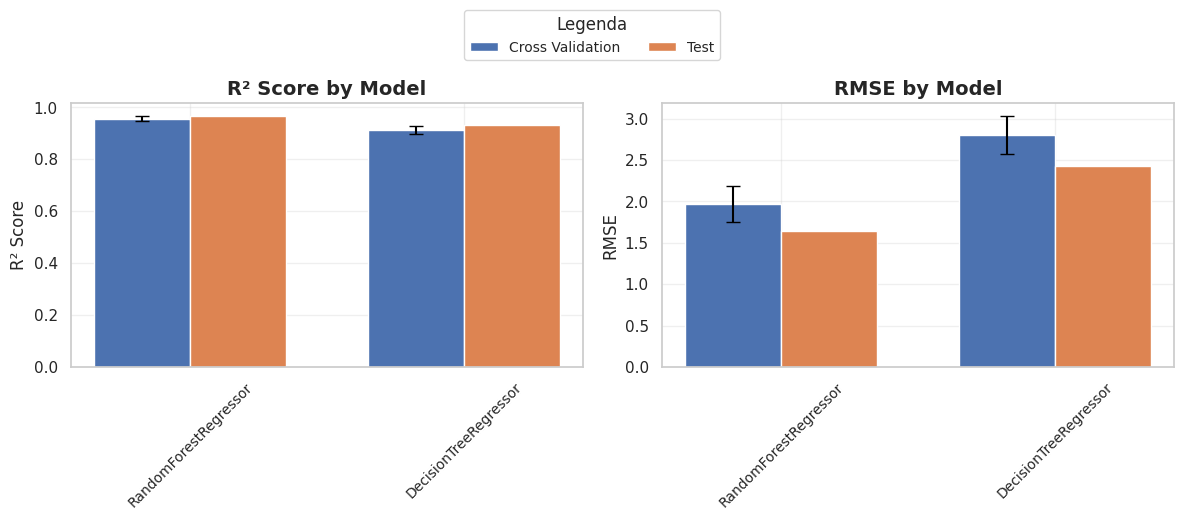

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

models = list(results.keys())
r2_cv = [results[m]['cv_r2_mean'] for m in models]
r2_cv_std = [results[m]['cv_r2_std'] for m in models]
r2_test = [results[m]['test_r2'] for m in models]
rmse_cv = [results[m]['cv_rmse_mean'] for m in models]
rmse_cv_std = [results[m]['cv_rmse_std'] for m in models]
rmse_test = [results[m]['test_rmse'] for m in models]

# Plot 1: R^2 Score
x = np.arange(len(models))
width = 0.35

bar1_r2 = ax1.bar(x - width/2, r2_cv, width, label='Cross Validation',
                  yerr=r2_cv_std, capsize=5, ecolor='black')
bar2_r2 = ax1.bar(x + width/2, r2_test, width, label='Test')
ax1.set_title('R² Score by Model', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, fontsize=10)
ax1.set_ylabel("R² Score", fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: RMSE
bar1_rmse = ax2.bar(x - width/2, rmse_cv, width, label='Cross Validation',
                    yerr=rmse_cv_std, capsize=5, ecolor='black')
bar2_rmse = ax2.bar(x + width/2, rmse_test, width, label='Test')
ax2.set_title('RMSE by Model', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, fontsize=10)
ax2.set_ylabel("RMSE", fontsize=12)
ax2.grid(True, alpha=0.3)

# Criar uma única legenda compartilhada
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, 
           title="Legenda", 
           title_fontsize=12, 
           fontsize=10, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.05), 
           ncol=len(labels))

plt.tight_layout()
plt.subplots_adjust(top=0.85)

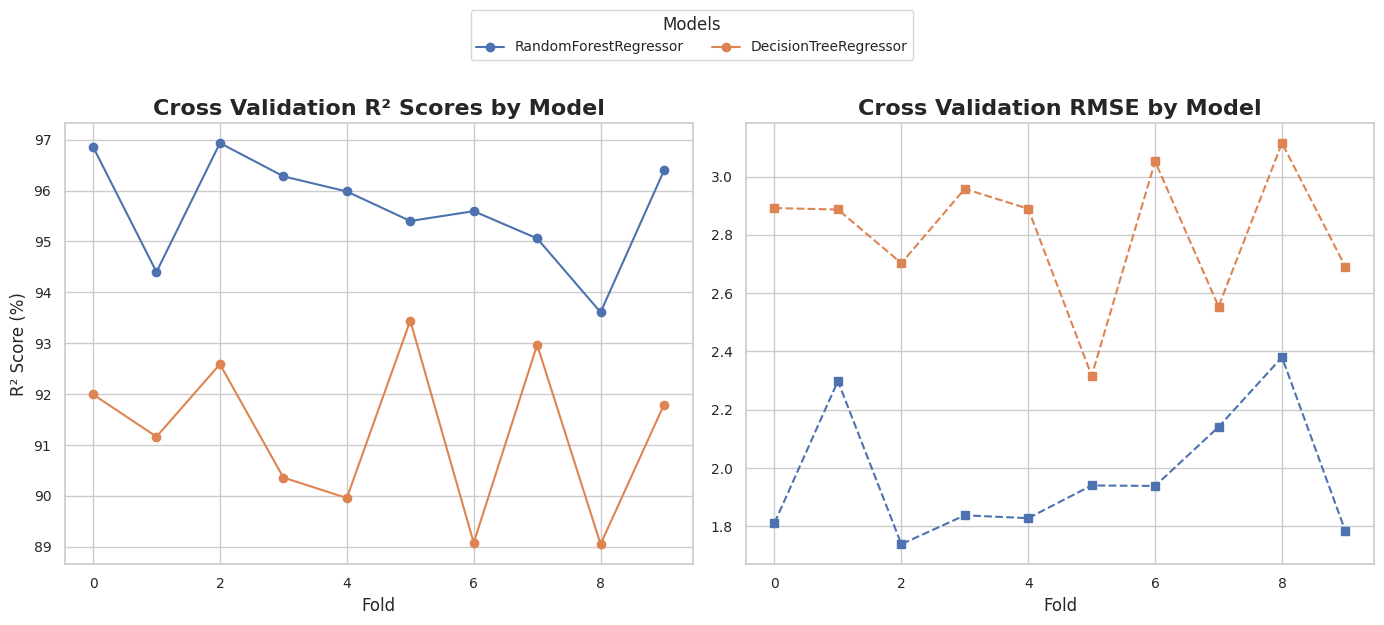

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Gráfico de R^2
for model_name, result in results.items():
    ax1.plot(np.arange(len(result['cv_r2'])), 
             result['cv_r2'] * 100, 
             marker="o", 
             label=model_name)
ax1.set_title("Cross Validation R² Scores by Model", fontsize=16, fontweight="bold")
ax1.set_xlabel("Fold", fontsize=12)
ax1.set_ylabel("R² Score (%)", fontsize=12)
ax1.tick_params(axis="x", labelsize=10)
ax1.tick_params(axis="y", labelsize=10)

# Gráfico de RMSE
for model_name, result in results.items():
    ax2.plot(np.arange(len(result['cv_rmse'])), 
             result['cv_rmse'], 
             marker="s", 
             linestyle="--", 
             label=model_name)
ax2.set_title("Cross Validation RMSE by Model", fontsize=16, fontweight="bold")
ax2.set_xlabel("Fold", fontsize=12)
ax2.tick_params(axis="x", labelsize=10)
ax2.tick_params(axis="y", labelsize=10)

# Adicionar uma única legenda compartilhada
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, 
           title="Models", 
           title_fontsize=12, 
           fontsize=10, 
           loc='upper center', 
           bbox_to_anchor=(0.5, 1.05), 
           ncol=len(labels))

plt.tight_layout()
plt.subplots_adjust(top=0.85)

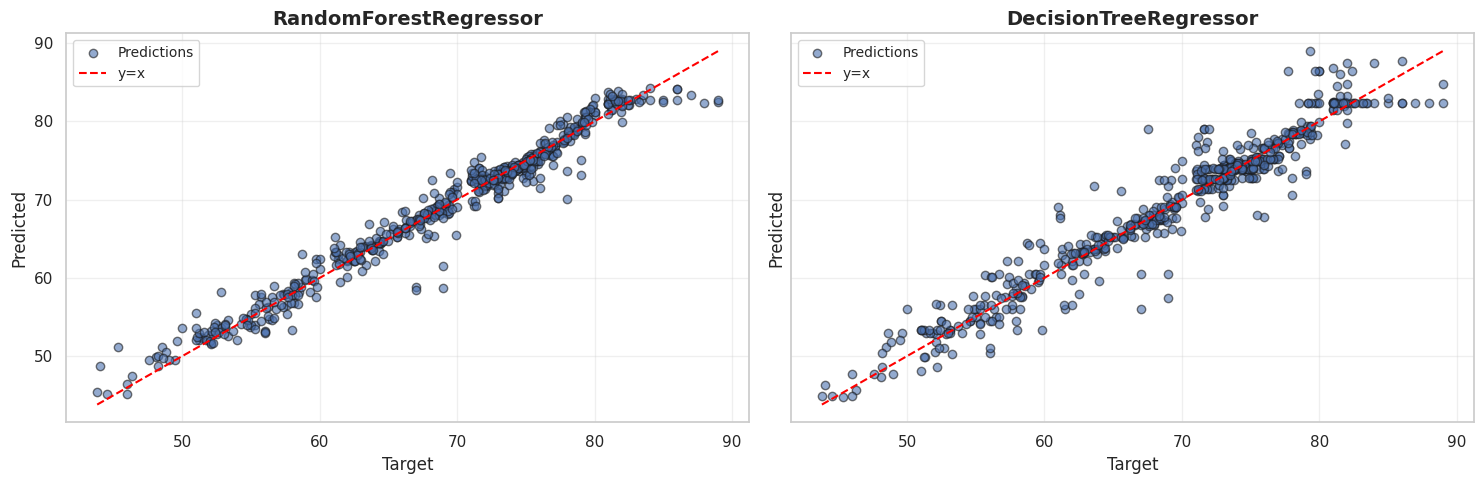

In [41]:
num_models = len(results)
cols = 2
rows = math.ceil(num_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharey=True)
axes = axes.flatten()

for ax, (model_name, result) in zip(axes, results.items()):
    y_test = result['y_test']
    y_pred = result['y_pred']
    
    ax.scatter(y_test, y_pred, alpha=0.6, edgecolor='k', label="Predictions")
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
            color='red', linestyle='--', label="y=x", linewidth=1.5)
    
    ax.set_title(model_name, fontsize=14, fontweight="bold")
    ax.set_xlabel("Target", fontsize=12)
    ax.set_ylabel("Predicted", fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)

for i in range(len(results), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()

## Best Model

In [42]:
best_model = None
best_metrics = None
best_score = float('inf')

for model_name, metrics in results.items():
    # Quanto menor o RMSE e maior o R², melhor o modelo
    # Usamos 1 - R² para ter uma métrica onde menor = melhor
    score = metrics['cv_rmse_mean'] * (1 - metrics['cv_r2_mean'])
    
    if score < best_score:
        best_score = score
        best_model = model_name
        best_metrics = {
            'CV RMSE (média)': round(metrics['cv_rmse_mean'], 4),
            'CV R² (média)': round(metrics['cv_r2_mean'], 4),
            'Test RMSE': round(metrics['test_rmse'], 4),
            'Test R²': round(metrics['test_r2'], 4)
        }

In [43]:
print(f"Best Model: {best_model}")
print("\nMetrics")
for metric, value in best_metrics.items():
    print(f"{metric}: {value}")

Best Model: RandomForestRegressor

Metrics
CV RMSE (média): 1.9694
CV R² (média): 0.9565
Test RMSE: 1.6475
Test R²: 0.9687


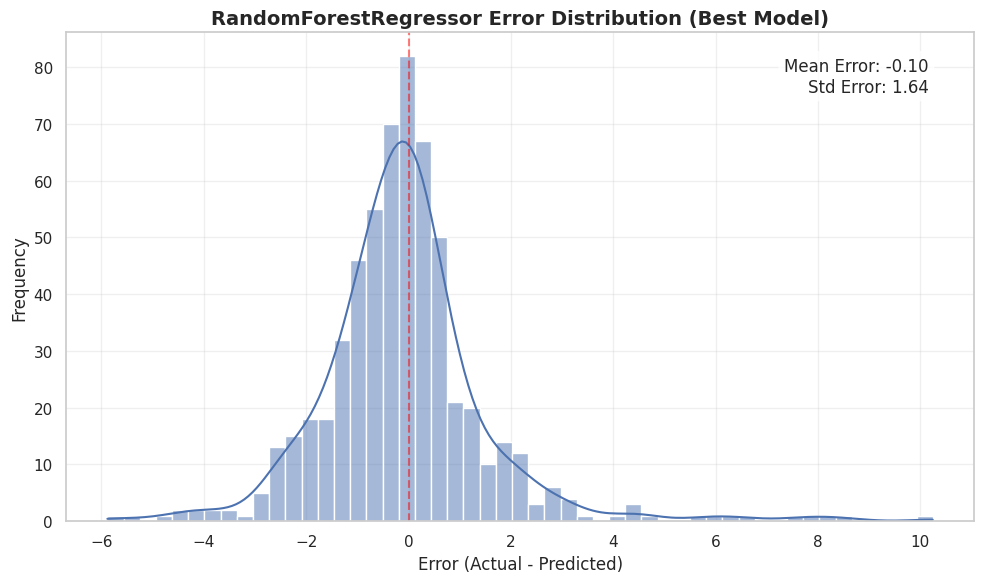

In [44]:
plt.figure(figsize=(10, 6))

errors = results[best_model]['y_test'] - results[best_model]['y_pred']

sns.histplot(errors, kde=True)

plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.title(f'{best_model} Error Distribution (Best Model)', fontsize=14, fontweight='bold')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')

plt.text(0.95, 0.95, 
         f'Mean Error: {np.mean(errors):.2f}\nStd Error: {np.std(errors):.2f}',
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()